In [286]:
import pandas as pd 
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt 

In [287]:
db_path = "/Users/yuta/Desktop/climb_proj/instance/climbs.db"

connection = sqlite3.connect(db_path)
cursor = connection.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('users',), ('climbs',), ('score',), ('comments',)]


In [288]:
import os 
print(os.path.abspath(db_path))

/Users/yuta/Desktop/climb_proj/instance/climbs.db


In [289]:
query_climb = 'SELECT * FROM climbs'
climbs_df = pd.read_sql_query(query_climb, connection)
climbs_df 

query_user = 'SELECT * FROM users'
user_df = pd.read_sql_query(query_user, connection)
user_df

query_score = 'SELECT * FROM score'
score_df = pd.read_sql_query(query_score, connection)
score_df

,id,performance_score,activity_score,grade,score_owner_id,recorded_at
0,1,73,286,8,3,2024-12-06 17:55:17.304365
1,2,91,217,7,3,2024-12-05 17:55:17.304365
2,3,97,202,4,3,2024-12-04 17:55:17.304365
3,4,75,279,4,3,2024-12-03 17:55:17.304365
4,5,100,163,9,3,2024-12-02 17:55:17.304365
5,6,94,374,8,3,2024-12-01 17:55:17.304365
6,7,78,479,8,3,2024-11-30 17:55:17.304365


In [290]:
# this returns today's climbing activity of user with specified id
def excercise_today(id):
    user_climb_data = climbs_df[climbs_df.upload_author_id==id] # make the value inside upload_author_id dynamic
    user_climb_data['date_logged'] = pd.to_datetime(user_climb_data.date_logged) # convert the value to datetime format for conpatibility
    user_data_today = user_climb_data[user_climb_data['date_logged'].dt.date == datetime.now().date()]
    if user_data_today.empty: # need to implement error handling in case there is no excersize history that day
        return None
    else:
        return user_data_today
    
# climbs_completed = excercise_today(3)[excercise_today(3).completed == True]
# climbs_completed

In [291]:
# this returns max_grade of the user with specified id 
def user_max(id):
    user_detail = user_df[user_df.id == id]
    return int(user_detail.current_grade)

# user_max(3)

In [292]:
# this returns performance score based solely on the attempt number and the grade which is before being refined to the final score 

def performance_score(id):
    max_attempts = 100
    grade = excercise_today(id)[excercise_today(id).completed == True].grade # this ensures that its getting only completed climbs
    user_max_grade = user_max(id)
    user_attempt = excercise_today(id)[excercise_today(id).completed == True].attempt # this ensures that its getting only completed climbs
    intensity_level = grade / user_max_grade
    score = intensity_level * (max_attempts / (user_attempt + max_attempts)) * 100
    print(score)
    return int(score.mean())

# performance_score(3)


In [293]:
def final_score(id):
    score = performance_score(id)
    user_max_grade = user_max(id)
    climbs_completed = excercise_today(id)[excercise_today(id).completed == True]
    completed_climb_num = climbs_completed.count().grade
    completed_climb_num

    # add or deduct number from perfromnace score based on the number of climbs completed
    if completed_climb_num == 1:
        score -= 10
    elif completed_climb_num == 2:
        score -= 8
    elif completed_climb_num == 3:
        score -= 6
    elif completed_climb_num == 4:
        score -= 4
    elif completed_climb_num == 5:
        score += 3
    elif completed_climb_num == 6:
        score += 5
    elif completed_climb_num > 6:
        score += 7

    # give extra score if the user cpmpleted climbs with the grade higher than the grade 2 grades lower than their max grade
    base_hard_climbs = climbs_completed[climbs_completed.grade >= user_max_grade -2].count().id
    score += base_hard_climbs * 2
    score

    # give extra score if the user cpmpleted their max grade
    max_grade = climbs_completed[climbs_completed.grade == user_max_grade].count().id
    score += max_grade * 3

    # give extra score if the user cpmpleted climbs with the grade higher than their max grade
    hard_grade = climbs_completed[climbs_completed.grade > user_max_grade].count().id
    score += hard_grade * 5
    
    if score > 100:
        score = 100
    return score

print(final_score(3))

21    58.823529
25    58.823529
26    92.592593
28    76.923077
29    75.471698
dtype: float64
88


/var/folders/80/hv8gpdgn6tndvgyr9pwntpz40000gn/T/ipykernel_70942/13646849.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_climb_data['date_logged'] = pd.to_datetime(user_climb_data.date_logged) # convert the value to datetime format for conpatibility
/var/folders/80/hv8gpdgn6tndvgyr9pwntpz40000gn/T/ipykernel_70942/13646849.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_climb_data['date_logged'] = pd.to_datetime(user_climb_data.date_logged) # convert the value to datetime format for conpat

In [294]:
score_df['recorded_at'] = pd.to_datetime(score_df.recorded_at)
score_df['date'] = score_df['recorded_at'].dt.date
score_df
latest_per_day = score_df.loc[score_df.groupby('date')['recorded_at'].idxmax()]
latest_per_day

,id,performance_score,activity_score,grade,score_owner_id,recorded_at,date
6,7,78,479,8,3,2024-11-30 17:55:17.304365,2024-11-30
5,6,94,374,8,3,2024-12-01 17:55:17.304365,2024-12-01
4,5,100,163,9,3,2024-12-02 17:55:17.304365,2024-12-02
3,4,75,279,4,3,2024-12-03 17:55:17.304365,2024-12-03
2,3,97,202,4,3,2024-12-04 17:55:17.304365,2024-12-04
1,2,91,217,7,3,2024-12-05 17:55:17.304365,2024-12-05
0,1,73,286,8,3,2024-12-06 17:55:17.304365,2024-12-06


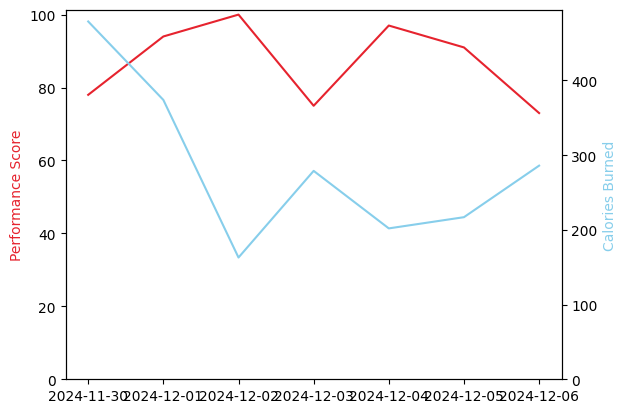

In [295]:
ax1 = plt.gca()  # Get the current axis
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis

# Set axis labels
ax1.set_ylabel('Performance Score', color='#E6232E')
ax2.set_ylabel('Calories Burned', color='skyblue')

# Plot data on respective axes
ax1.plot(latest_per_day.date, latest_per_day.performance_score, color='#E6232E')
ax2.plot(latest_per_day.date, latest_per_day.activity_score, color='skyblue')

# Set the y-axis minimum to 0 for both axes
ax1.set_ylim(bottom=0)  # Set min value for the primary axis (Performance Score)
ax2.set_ylim(bottom=0)  # Set min value for the secondary axis (Calories Burned)

# Display the plot
plt.show()

In [296]:
latest_per_day = score_df.loc[score_df.groupby('date')['recorded_at'].idxmax()]
latest_per_day[['grade', 'date']] # need to find a way to get the mean num for grade throughout a week 

,grade,date
6,8,2024-11-30
5,8,2024-12-01
4,9,2024-12-02
3,4,2024-12-03
2,4,2024-12-04
1,7,2024-12-05
0,8,2024-12-06


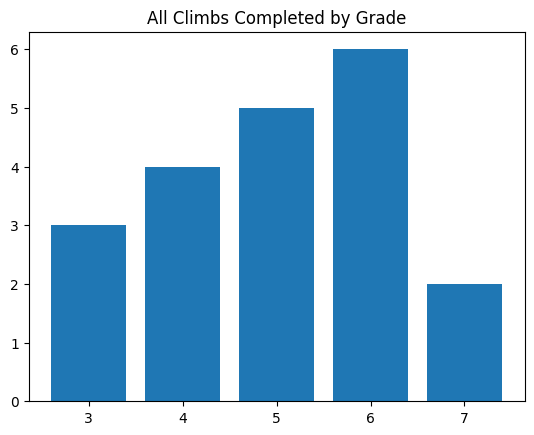

In [297]:
user_climbs = climbs_df[climbs_df['upload_author_id'] == 3]
filtered_users_climbs = user_climbs[user_climbs['completed'] == True]
total_grade_completed = filtered_users_climbs.groupby('grade').count()


plt.bar(
    total_grade_completed.index,  # Labels for each style (on x-axis)
    total_grade_completed['id']   # Values for each style (on y-axis)
)

# Add a title
plt.title('All Climbs Completed by Grade')

# Display the chart
plt.show()

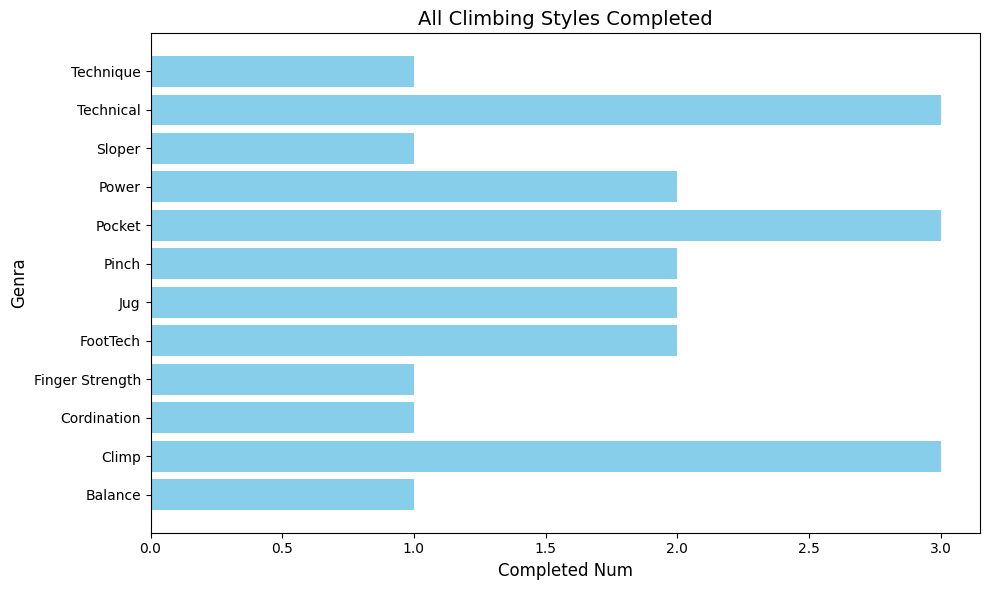

In [298]:
# this shows style of all the climbs completed
def style_completed(id):
    global user_climbs
    user_climbs = climbs_df[climbs_df['upload_author_id'] == id]

    total_completed = climbs_df[climbs_df.completed == True]
    total_completed = total_completed.groupby('style').count()
    by_style = total_completed[['id']]

   # Create the bar chart
    plt.figure(figsize=(10, 6))  # Set figure size
    plt.barh(
        by_style.index,  # Climb styles on y-axis
        by_style['id'],  # Number of attempts on x-axis
        color='skyblue'  # Bar color
    )
    plt.xlabel('Completed Num', fontsize=12)
    plt.ylabel('Genra', fontsize=12)
    plt.title('All Climbing Styles Completed', fontsize=14)
    plt.tight_layout()
    plt.show()

style_completed(3)

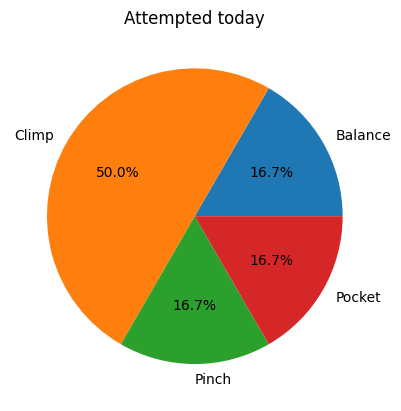

In [299]:
# this shows the style of climbs user attempted today 
def style_attempted(id):
    global user_climbs
    user_climbs = climbs_df[climbs_df['upload_author_id'] == id]
    climbs_df['date_logged'] = pd.to_datetime(climbs_df.date_logged).dt.date
    total_today = climbs_df[climbs_df.date_logged == datetime.now().date()]
    total_today = total_today.groupby('style').count()
    by_style = total_today[['id']]

    plt.pie(
        by_style['id'],  # Values for the pie chart
        labels=by_style.index,  # Labels for each style
        autopct='%1.1f%%'  # Show percentages
    )
    plt.title('Attempted today')

style_attempted(3)

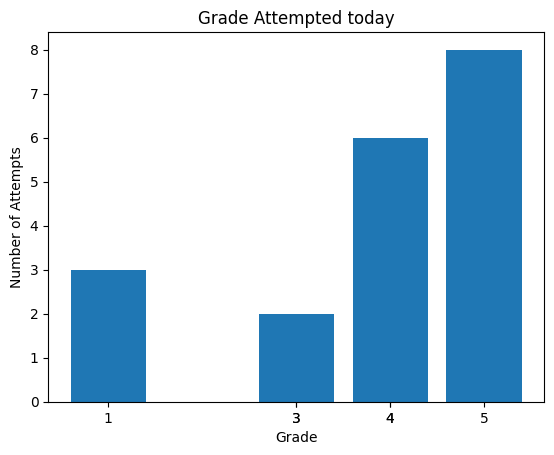

In [300]:
def grade_attempted(id):
    global user_climbs
    user_climbs[user_climbs.completed == True]
    user_climbs = climbs_df[climbs_df['upload_author_id'] == id]
    climbs_df['date_logged'] = pd.to_datetime(climbs_df.date_logged).dt.date
    total_today = climbs_df[climbs_df.date_logged == datetime.now().date()]
    filtered_total_today = total_today[['grade', 'attempt']]
    plt.bar(
        filtered_total_today['grade'],  # X-axis: grade values
        filtered_total_today['attempt']  # Y-axis: attempt values
    )

    # Add labels and title
    plt.xlabel('Grade')  # Label for the x-axis
    plt.ylabel('Number of Attempts')  # Label for the y-axis
    plt.title('Grade Attempted today')  # Title of the chart
    plt.xticks(ticks=filtered_total_today['grade'], labels=filtered_total_today['grade'])

    # Display the chart
    plt.show()
grade_attempted(3)